In [1]:
#@title imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from torch.optim.lr_scheduler import ExponentialLR

In [2]:
# @title Gaussian Mixtures

def sample_gmm(n, weights, means, sds):

  # Sample component indices
  components = np.random.choice(len(weights), size=n, p=weights)
  sample_mean = np.array(means)[components]
  sample_sds = np.array(sds)[components]

  samples = np.random.normal(sample_mean, sample_sds, size = n)
  return torch.tensor(samples, dtype=torch.float32)


In [3]:
#@title SBm Class
class SBM(nn.Module):
  def __init__(self, nnet, sigma, D, T):
    super(SBM, self).__init__()
    self.sigma = torch.tensor([sigma])

    # variance 
    self.var = self.sigma**2
    self.prior = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(D), self.var * torch.eye(D))

    # score network model 
    self.net = nnet
    self.time_embed = nn.Sequential(nn.Linear(1, D))

    self.D = D
    self.T = T
    self.eps = 1e-5

  # variance of brownian
  def sigma_fn(self, t):
    return (torch.exp(2*t) -1)/2 + self.var

  def log_p_prior(self, x): #log prior
    log_p = self.prior.log_prob(x)
    return log_p

  def sample_prior(self, x0): # samples from prior
    return self.prior.rsample(sample_shape=torch.Size([x0.shape[0]]))

  def sample_pt(self, x0, t):
      mean = x0
      var = self.sigma_fn(t)**2
      return mean + torch.sqrt(var) * torch.randn_like(x0)

  def lambda_t(self, t):
    # the loss weighting
    return self.sigma_fn(t)**2

  def diffusion(self, t):
    return torch.exp(t) 

  def forward(self, x0):
      t = torch.rand(size=(x0.shape[0], 1)) * (1. - self.eps) + self.eps
      
      # Sample x_t
      x_t = self.sample_pt(x0, t)
      
      # True score
      score = -(x_t - x0) / self.sigma_fn(t)**2
      
      # Predicted score
      t_embed = self.time_embed(t)
      score_pred = self.net(torch.cat([x_t, t_embed], dim=1))
      
      # Score matching loss with lambda(t) weighting
      loss_per_element = (score - score_pred)**2 * self.lambda_t(t)
      loss = torch.mean(torch.sum(loss_per_element, dim=1))
      
      return loss

  def sample(self, batch_size=64):
      x = torch.randn(batch_size, self.D)
      #x = self.sample_pt(x0, torch.tensor([1.0]))

      ts = torch.linspace(1., self.eps, self.T)
      dt = ts[1] - ts[0]
      
      for i in range(len(ts)-1):
          t = ts[i]
          
          # Predict score
          t_embed = self.time_embed(torch.full((batch_size, 1), t))
          score = self.net(torch.cat([x, t_embed], dim=1))
          
          # Reverse SDE update
          g_t = self.diffusion(t)
          drift = -(g_t**2) * score
          noise = g_t * torch.randn_like(x) * torch.sqrt(torch.abs(dt))
          x = x + drift * dt + noise
          
      return x

  def log_prob_obj(self, x0):
      ts = torch.linspace(self.eps, 1., self.T)
      obj = 0  
      
      for t in ts:
          x_1 = torch.randn_like(x0)
          x_t = self.sample_pt(x0, t)

          true_score = -(x_t - x0) / self.sigma_fn(t)**2
          
          t_batch = torch.full((x0.shape[0], 1), t)
          t_embd = self.time_embed(t_batch)          
          x_pred = self.net(torch.cat([x_t, t_embd], dim=1)) 

          obj = obj + self.lambda_t(t) * torch.pow(true_score - x_pred, 2).mean(-1)
      
      return obj.mean()

In [4]:
#@title initialize model
# Initialize the model
D = 1  # Dimension of the data
M = 256  # Hidden layer size
T = 100  # Number of time steps
sigma = 1.01

nnet = nn.Sequential(
    nn.Linear(D +D , M), nn.ReLU(),
    nn.Linear(M, M), nn.ReLU(),
    nn.Linear(M, M), nn.ReLU(),
    nn.Linear(M, M), nn.ReLU(),
    nn.Linear(M, D))

model = SBM(nnet, sigma=sigma, D=D, T=T)

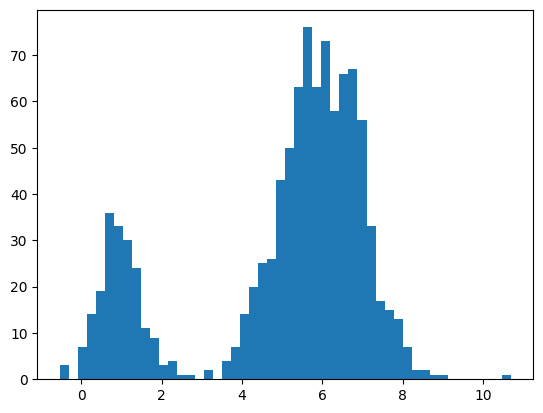

In [5]:
#@title Prepare data
n_traj = 1000
gmm_samples = sample_gmm(n_traj, weights=[0.2, 0.8], means=[1, 6], sds=[0.5, 1])
dataset = TensorDataset(gmm_samples.unsqueeze(-1))

# train/val/test splits
n_train = int(0.7 * len(gmm_samples))
n_val = int(0.15 * len(gmm_samples))

train_data = gmm_samples[:n_train]
val_data = gmm_samples[n_train:n_train+n_val]
test_data = gmm_samples[n_train+n_val:]


train_dataset = TensorDataset(train_data.unsqueeze(-1))
val_dataset = TensorDataset(val_data.unsqueeze(-1))
test_dataset = TensorDataset(test_data.unsqueeze(-1))

# data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

plt.hist(gmm_samples, bins = 50)

# optimizer
optimizer = torch.optim.Adamax(model.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma = 0.9)

In [6]:
def evaluation(test_loader, name=None, model_best=None, epoch=None, verbose = False):
    # EVALUATION
    if model_best is None:
        # load best performing model
        model_best = torch.load(name + '.model')

    model_best.eval()
    loss = 0.
    N = 0.

    for indx_batch, test_batch in enumerate(test_loader):
        data = test_batch[0]
        loss_t = model_best.log_prob_obj(data)
        loss = loss + loss_t.item()
        N = N + data.shape[0]
    loss = loss / N

    return loss

  0%|          | 1/1001 [00:00<06:17,  2.65it/s]

Epoch 0: Train Loss: 0.8051, Val Loss: 1.3811


100%|██████████| 1001/1001 [07:34<00:00,  2.20it/s]

Epoch 1000: Train Loss: 0.5276, Val Loss: 1.2059


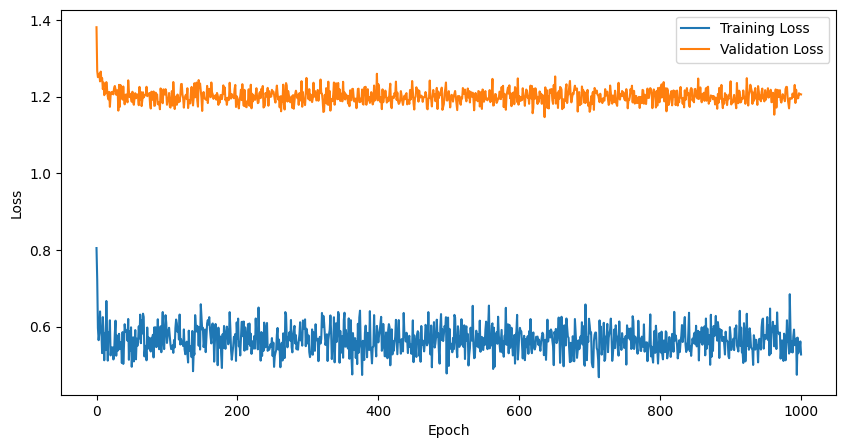

In [7]:
# Training loop
num_epochs = 1001
best_val_loss = float('inf')
train_losses = []
val_losses = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_loss = 0.0
    num_batches = 0

    # Training phase
    for batch in train_loader:
        x0 = batch[0]
        loss = model(x0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

    avg_train_loss = epoch_loss / num_batches
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_loss = evaluation(val_loader, model_best=model, epoch=epoch)
        val_losses.append(val_loss)

    scheduler.step()

    if epoch % 1000 == 0:  # Print more frequently
        print(f'Epoch {epoch}: Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}')


# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

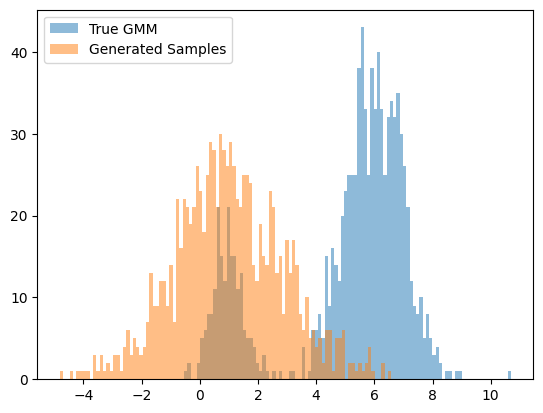

In [8]:
# Generate samples from the trained model
samples = model.sample(batch_size=1000).detach().numpy()

# Plot the results
plt.hist(gmm_samples.numpy(), bins=100, alpha=0.5, label='True GMM')
plt.hist(samples, bins=100, alpha=0.5, label='Generated Samples')
plt.legend()
plt.show()

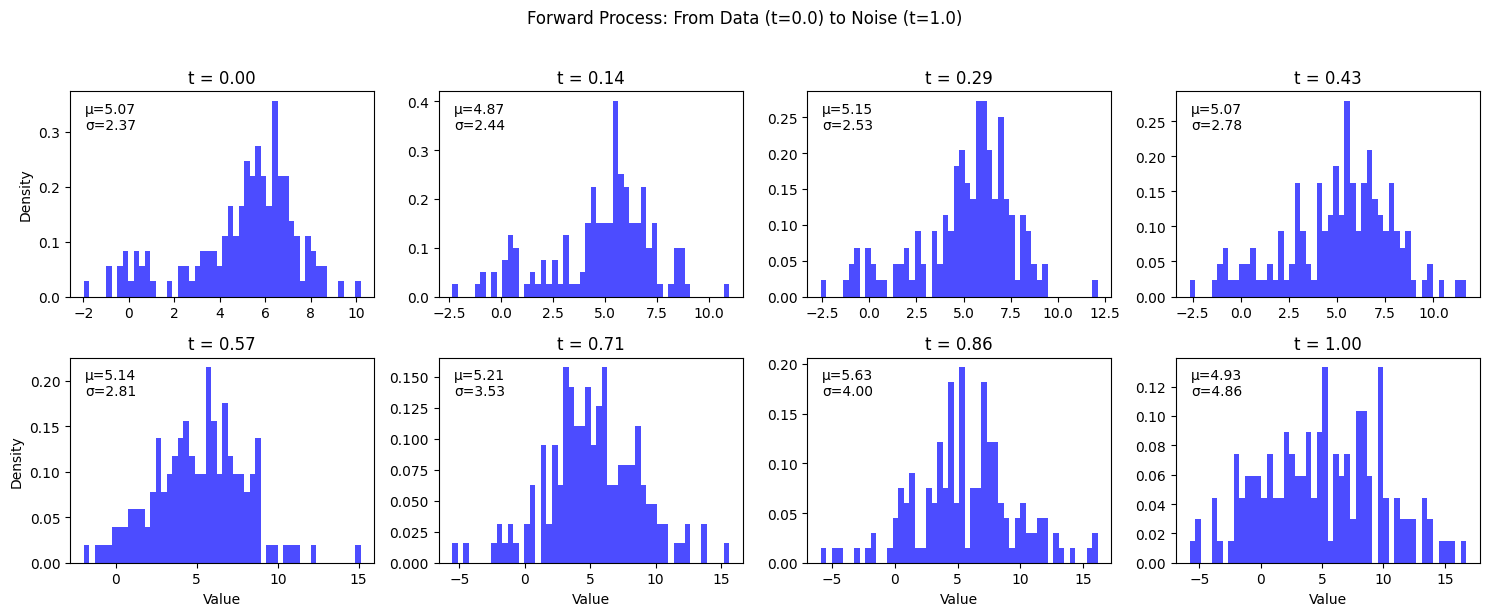

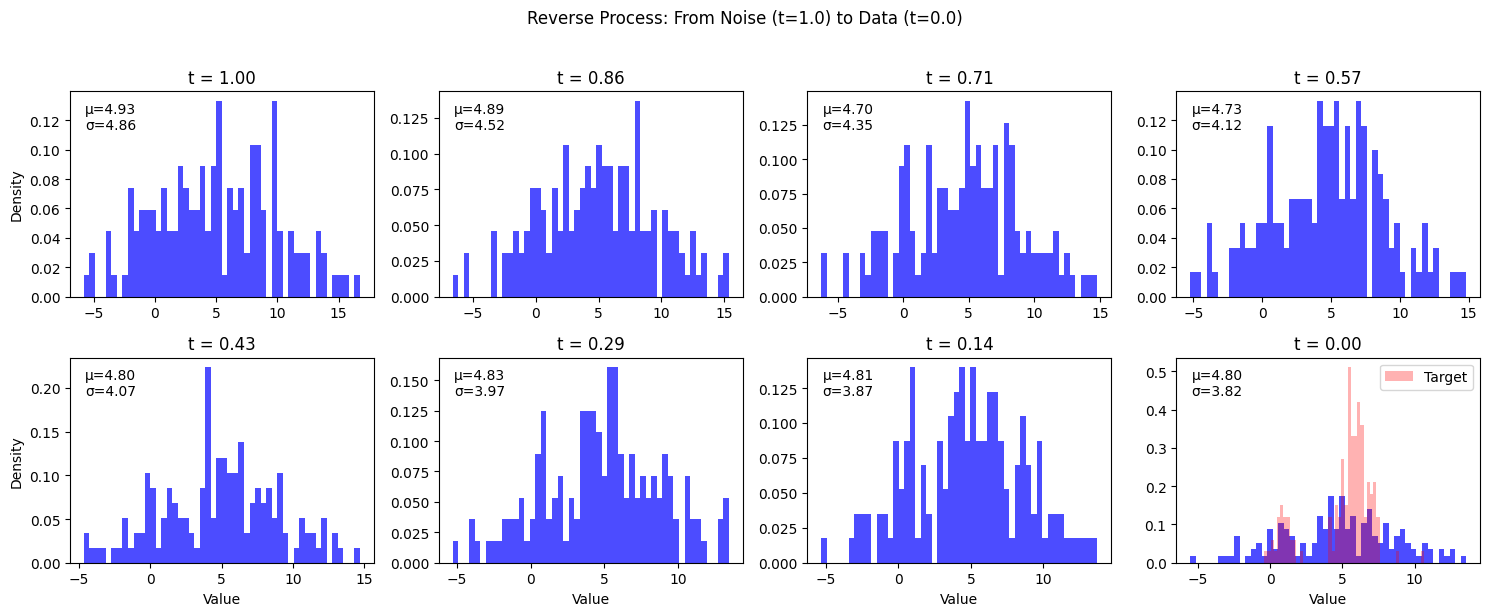

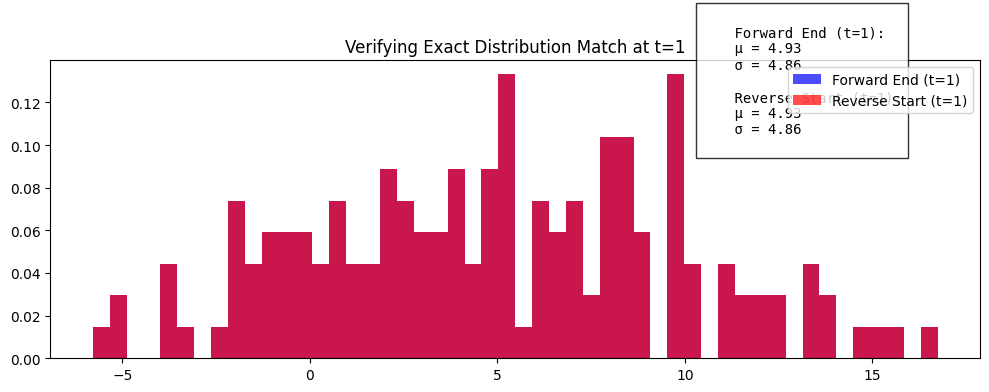

In [9]:
#@title Plotting trajectories and distributions
def plot_forward_and_reverse_processes(model, test_data, num_samples=150, num_timesteps=8):
    """
    Visualizes both forward and reverse processes with consistent samples at t=1.0
    """
    model.eval()
    num_samples = min(num_samples, len(test_data))
    
    # Calculate subplot layouts
    n_rows = (num_timesteps + 3) // 4
    n_cols = min(4, num_timesteps)
    
    # Create two figures
    plt.figure(figsize=(15, 3*n_rows))
    
    # Forward process timesteps
    forward_ts = torch.linspace(0., 1., num_timesteps)
    # Store the exact samples at each forward timestep
    forward_states = []
    
    # Generate forward process states
    x0 = test_data[:num_samples].unsqueeze(-1)
    
    with torch.no_grad():
        for t in forward_ts:
            perturbed = model.sample_pt(x0, torch.tensor([t]))
            forward_states.append(perturbed.detach().numpy().copy())
    
    # Plot forward process
    for idx, samples in enumerate(forward_states):
        plt.subplot(n_rows, n_cols, idx + 1)
        plt.hist(samples, bins=50, density=True, alpha=0.7, color='blue')
        
        t_val = forward_ts[idx].item()
        plt.title(f't = {t_val:.2f}')
        
        if idx % n_cols == 0:
            plt.ylabel('Density')
        if idx >= len(forward_states) - n_cols:
            plt.xlabel('Value')
        
        mean = np.mean(samples)
        std = np.std(samples)
        plt.text(0.05, 0.95, f'μ={mean:.2f}\nσ={std:.2f}',
                transform=plt.gca().transAxes,
                verticalalignment='top')
    
    plt.suptitle('Forward Process: From Data (t=0.0) to Noise (t=1.0)', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Now plot reverse process using the exact same endpoint
    plt.figure(figsize=(15, 3*n_rows))
    
    # Start reverse process with the exact same samples from forward process end
    x = torch.tensor(forward_states[-1], dtype=torch.float32)
    
    # Reverse process timesteps
    reverse_ts = torch.linspace(1., model.eps, num_timesteps)
    dt = reverse_ts[1] - reverse_ts[0]
    
    # Store reverse process states
    reverse_states = [x.numpy().copy()]
    
    # Perform reverse SDE
    with torch.no_grad():
        for i in range(len(reverse_ts)-1):
            t = reverse_ts[i]
            t_batch = torch.full((x.shape[0], 1), t)
            t_embed = model.time_embed(t_batch)
            score = model.net(torch.cat([x, t_embed], dim=1))
            drift = -model.diffusion(t)**2 * score
            noise = model.diffusion(t) * torch.randn_like(x) * torch.sqrt(torch.abs(dt))
            x = x + drift * dt + noise
            reverse_states.append(x.detach().numpy().copy())
    
    # Plot reverse process
    for idx, samples in enumerate(reverse_states):
        plt.subplot(n_rows, n_cols, idx + 1)
        plt.hist(samples, bins=50, density=True, alpha=0.7, color='blue')
        
        if idx == len(reverse_states)-1:
            plt.hist(test_data[:num_samples].numpy(), bins=50, density=True, 
                    alpha=0.3, label='Target', color='red')
            plt.legend()
        
        t_val = reverse_ts[min(idx, len(reverse_ts)-1)].item()
        plt.title(f't = {t_val:.2f}')
        
        if idx % n_cols == 0:
            plt.ylabel('Density')
        if idx >= len(reverse_states) - n_cols:
            plt.xlabel('Value')
        
        mean = np.mean(samples)
        std = np.std(samples)
        plt.text(0.05, 0.95, f'μ={mean:.2f}\nσ={std:.2f}',
                transform=plt.gca().transAxes,
                verticalalignment='top')
    
    plt.suptitle('Reverse Process: From Noise (t=1.0) to Data (t=0.0)', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Plot comparison at t=1.0
    plt.figure(figsize=(10, 4))
    plt.hist(forward_states[-1], bins=50, density=True, alpha=0.7,
            label='Forward End (t=1)', color='blue')
    plt.hist(reverse_states[0], bins=50, density=True, alpha=0.7,
            label='Reverse Start (t=1)', color='red')
    plt.title('Verifying Exact Distribution Match at t=1')
    plt.legend()
    
    # Add stats comparison
    stats_text = f"""
    Forward End (t=1):
    μ = {np.mean(forward_states[-1]):.2f}
    σ = {np.std(forward_states[-1]):.2f}
    
    Reverse Start (t=1):
    μ = {np.mean(reverse_states[0]):.2f}
    σ = {np.std(reverse_states[0]):.2f}
    """
    plt.text(0.7, 0.7, stats_text, transform=plt.gca().transAxes,
            fontsize=10, family='monospace', bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_forward_and_reverse_processes(model, test_data)